In [213]:
# exploring RFW data
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import models,transforms
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
import csv
import collections
from  PIL import Image
from tqdm.notebook import tqdm_notebook

In [91]:
# create df to contain all identities, their image file names, their ethnicities
path = "data/RFW/images/test/txts/"
img_path = 'data/RFW/images/test/data/'

# African images
african_images = pd.read_csv(path + 'African/African_images.txt', sep="\t", header=None)
african_images.columns = ['File', 'Label']
african_images['identityID'] = african_images['File'].str[:-9]
african_images['faceID'] = african_images['File'].str[-8:-4]
african_images['Ethnicity'] = 'African'
# Asian images
asian_images = pd.read_csv(path + 'Asian/Asian_images.txt', sep="\t", header=None)
asian_images.columns = ['File', 'Label']
asian_images['identityID'] = asian_images['File'].str[:-9]
asian_images['faceID'] = asian_images['File'].str[-8:-4]
asian_images['Ethnicity'] = 'Asian'
# Caucasian images
caucasian_images = pd.read_csv(path + 'Caucasian/Caucasian_images.txt', sep="\t", header=None)
caucasian_images.columns = ['File', 'Label']
caucasian_images['identityID'] = caucasian_images['File'].str[:-9]
caucasian_images['faceID'] = caucasian_images['File'].str[-8:-4]
caucasian_images['Ethnicity'] = 'Caucasian'
# Indian images
indian_images = pd.read_csv(path + 'Indian/Indian_images.txt', sep="\t", header=None)
indian_images.columns = ['File', 'Label']
indian_images['identityID'] = indian_images['File'].str[:-9]
indian_images['faceID'] = indian_images['File'].str[-8:-4]
indian_images['Ethnicity'] = 'Indian'
all_images = pd.concat([african_images,asian_images,caucasian_images,indian_images])
all_images

,File,Label,identityID,faceID,Ethnicity
0,m.0c7mh2_0003.jpg,0,m.0c7mh2,0003,African
1,m.0c7mh2_0001.jpg,0,m.0c7mh2,0001,African
2,m.0c7mh2_0002.jpg,0,m.0c7mh2,0002,African
3,m.026tq86_0003.jpg,1,m.026tq86,0003,African
4,m.026tq86_0001.jpg,1,m.026tq86,0001,African
...,...,...,...,...,...
10303,m.027nbyf_0002.jpg,2982,m.027nbyf,0002,Indian
10304,m.027nbyf_0001.jpg,2982,m.027nbyf,0001,Indian
10305,m.027nbyf_0005.jpg,2982,m.027nbyf,0005,Indian
10306,m.098d5s_0002.jpg,2983,m.098d5s,0002,Indian


In [92]:
# remove any duplicate identities
v = all_images.reset_index().groupby('identityID').Ethnicity.nunique()
dup = v[v>1].index.tolist()
all_images = all_images[~all_images['identityID'].isin(dup)]
all_images

,File,Label,identityID,faceID,Ethnicity
0,m.0c7mh2_0003.jpg,0,m.0c7mh2,0003,African
1,m.0c7mh2_0001.jpg,0,m.0c7mh2,0001,African
2,m.0c7mh2_0002.jpg,0,m.0c7mh2,0002,African
3,m.026tq86_0003.jpg,1,m.026tq86,0003,African
4,m.026tq86_0001.jpg,1,m.026tq86,0001,African
...,...,...,...,...,...
10303,m.027nbyf_0002.jpg,2982,m.027nbyf,0002,Indian
10304,m.027nbyf_0001.jpg,2982,m.027nbyf,0001,Indian
10305,m.027nbyf_0005.jpg,2982,m.027nbyf,0005,Indian
10306,m.098d5s_0002.jpg,2983,m.098d5s,0002,Indian


In [93]:
# get first image from each identity and use it as reference
identities = np.array(all_images.identityID.unique().tolist()).astype(object)
file_end =  np.array('_0001.jpg'.split()*len(identities)).astype(object)
first_images = identities + file_end
first_images

array(['m.0c7mh2_0001.jpg', 'm.026tq86_0001.jpg', 'm.02wz3nc_0001.jpg',
       ..., 'm.02793d7_0001.jpg', 'm.027nbyf_0001.jpg',
       'm.098d5s_0001.jpg'], dtype=object)

In [117]:
references = all_images[all_images['File'].isin(first_images)]
candidates = all_images[~all_images['File'].isin(first_images)]
print(len(references),len(candidates))

11403 29117


In [176]:
# create dataset class for RFW
class resnetRFW(data.Dataset):
    
    '''
    This will be a class to load data from RFW for resnet50 model
    '''
     
    mean_bgr = np.array([91.4953, 103.8827, 131.0912])  # from resnet50_ft.prototxt

    def __init__(self,img_path,img_df):
        """
        :param img_path: dataset directory
        :param img_df: contains image file names and other information
        """
        assert os.path.exists(img_path), "root: {} not found.".format(img_path)
        self.img_path = img_path
        self.img_df = img_df
        self.img_info = []

        for i, row in self.img_df.iterrows():
            self.img_info.append({
                'img_file': row.Ethnicity + '/' + row.identityID + '/' + row.File,
                'identityID': row.identityID,
                'Ethnicity': row.Ethnicity,
            })
            if i % 5000 == 0:
                print("processing: {} images".format(i))

    def __len__(self):
        return len(self.img_info)

    def __getitem__(self, index):
        info = self.img_info[index]
        img_file = info['img_file']
        img = Image.open(os.path.join(self.img_path, img_file))
        img = transforms.Resize(256)(img)
        img = transforms.CenterCrop(224)(img)
        img = np.array(img, dtype=np.uint8)
        assert len(img.shape) == 3  # assumes color images and no alpha channel

        Ethnicity = info['Ethnicity']
        identityID = info['identityID']
        return self.transform(img), identityID, Ethnicity, img_file
  

    def transform(self, img):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float32)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1)  # C x H x W
        img = torch.from_numpy(img).float()
        return img

    def untransform(self, img, lbl):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img += self.mean_bgr
        img = img.astype(np.uint8)
        img = img[:, :, ::-1]
        return img, lbl

def load_resnet50(weights="weights/resnet50_scratch_weight.pkl"):
    # load resnet50 model and modify it to match the one from the github to load the weights from the pkl
# resnet50 trained on VGGFace2
    resnet50 = models.resnet50(pretrained=False)
    resnet50.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    resnet50.layer2[0].conv1 = nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    resnet50.layer2[0].conv2 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    resnet50.layer3[0].conv1 = nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
    resnet50.layer3[0].conv2 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    resnet50.layer4[0].conv1 = nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    resnet50.layer4[0].conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    resnet50.avgpool = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)
    resnet50.fc = nn.Linear(in_features=2048,out_features=8631)
    with open("weights/resnet50_scratch_weight.pkl", 'rb') as f:
        weights = pickle.load(f, encoding='latin1')
    weights = dict(map(lambda x: (x[0], torch.from_numpy(x[1])), weights.items()))
    weights = OrderedDict(weights)
    resnet50.load_state_dict(weights)
    resnet50 = torch.nn.Sequential(*(list(resnet50.children())[:-1]))
    return resnet50

In [177]:
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
# load reference images
reference_dataset = resnetRFW(img_path,references.reset_index(drop=True))
reference_loader = torch.utils.data.DataLoader(reference_dataset, batch_size=32, shuffle=False, **kwargs)
# load candidate images
candidate_dataset = resnetRFW(img_path,candidates.reset_index(drop=True))
candidate_loader = torch.utils.data.DataLoader(candidate_dataset, batch_size=32, shuffle=False, **kwargs)


processing: 0 images
processing: 5000 images
processing: 10000 images
processing: 0 images
processing: 5000 images
processing: 10000 images
processing: 15000 images
processing: 20000 images
processing: 25000 images


In [221]:
resnet50 = load_resnet50()
resnet50.eval()
# apply model to references
outputs = []
with torch.no_grad():
    for i, (imgs, target, img_files, class_ids) in tqdm_notebook(enumerate(reference_loader),total=len(reference_loader)):
        x = resnet50(imgs)
        out = x.view(x.size(0),-1)
        outputs.append(out)
outputs=torch.cat(outputs)
torch.save(outputs, 'reference_outputs.pt')

  0%|          | 0/357 [00:00<?, ?it/s]

In [224]:
# apply model to candidates
outputs = []
with torch.no_grad():
    for i, (imgs, target, img_files, class_ids) in tqdm_notebook(enumerate(candidate_loader),total=len(candidate_loader)):
        x = resnet50(imgs)
        out = x.view(x.size(0),-1)
        outputs.append(out)
outputs=torch.cat(outputs)
torch.save(outputs, 'candidate_outputs.pt')


  0%|          | 0/910 [00:00<?, ?it/s]

torch.Size([11403, 2048])

In [206]:
max_corr = []
min_corr = []

for i in range(32):
    corr = []
    for j in range(32):
        if i != j:
            c = np.corrcoef(x[i].detach().numpy(),x[j].detach().numpy())[0,1]
            corr.append(np.abs(c))
       # else:
    argmax = np.argmax(corr)
    argmin = np.argmin(corr)
    if argmax >= i:
        argmax +=1
    if argmin >= i:
        argmin +=1
    print('max for i = {0}: j = {1}, corr = {2}'.format(i,argmax,max(corr)))
    print('min for i = {0}: j = {1}, corr = {2}'.format(i,argmin,min(corr)))
    max_corr.append(max(corr))

max for i = 0: j = 3, corr = 0.38901322121260257
min for i = 0: j = 4, corr = 0.022605137380557406
max for i = 1: j = 18, corr = 0.3875218088735838
min for i = 1: j = 9, corr = 0.012501847329663801
max for i = 2: j = 4, corr = 0.4063488068652558
min for i = 2: j = 26, corr = 0.00328280125590529
max for i = 3: j = 0, corr = 0.38901322121260257
min for i = 3: j = 4, corr = 0.0068913847112812825
max for i = 4: j = 2, corr = 0.4063488068652558
min for i = 4: j = 12, corr = 0.0009572293600302497
max for i = 5: j = 0, corr = 0.3166823850910452
min for i = 5: j = 10, corr = 0.0013430385294494569
max for i = 6: j = 0, corr = 0.32765203286345707
min for i = 6: j = 24, corr = 0.009451667019346965
max for i = 7: j = 18, corr = 0.4002952241902353
min for i = 7: j = 23, corr = 0.001642578181981796
max for i = 8: j = 29, corr = 0.3887220516666942
min for i = 8: j = 5, corr = 0.034169113495319765
max for i = 9: j = 23, corr = 0.21156548389726595
min for i = 9: j = 19, corr = 0.0010580835226647167
max

In [196]:
references = references.reset_index(drop=True)

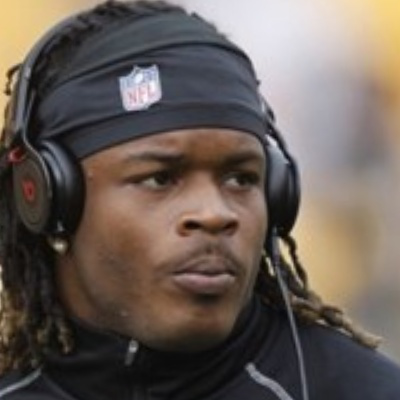

In [197]:
Image.open(img_path + references.Ethnicity[12]+ '/' + references.identityID[12]+ '/' + references.File[12])

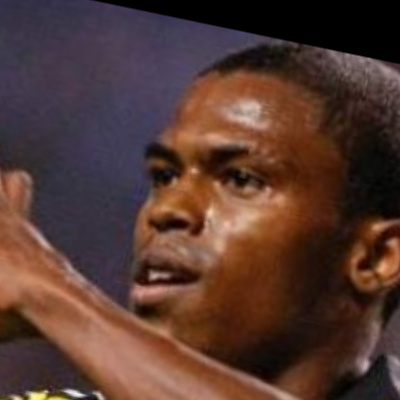

In [198]:
Image.open(img_path + references.Ethnicity[13]+ '/' + references.identityID[13]+ '/' + references.File[13])